In [2]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import random as rand
import queue
import csv
from collections import OrderedDict
from IPython.display import clear_output
import csv
from heapq import merge
from sklearn import preprocessing
import gc
import os
from os import listdir
from os.path import isfile, join
import shutil
from configparser import ConfigParser
import ast
import sys
import re
from pathlib import Path

from sklearn.datasets import make_circles, make_moons
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from IPython.core.debugger import set_trace
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

rand.seed(37)

#from src.snapconfig import config
from src.snaptrain import simulatespectra as sim
from src.snaptrain import process
from src.snaputils import reader

In [2]:
# Temporary config func. Original one in the project.
class config:
    """Define constants"""
    AAMass = {'A': 71.037114, 'C': 103.009185, 'D': 115.026943, 'E': 129.042593, 'F': 147.068414, 'G': 57.021464,
              'H': 137.058912, 'I': 113.084064, 'K': 128.094963, 'L': 113.084064, 'M': 131.040485, 'N': 114.042927,
              'P': 97.052764, 'Q': 128.058578, 'R': 156.101111, 'S': 87.032028, 'T': 101.047679, 'V': 99.068414,
              'W': 186.079313, 'Y': 163.0633}

    H2O = 18.015
    NH3 = 17.031
    PROTON = 1.00727647
    DEFAULT_PARAM_PATH = os.path.join(os.getcwd(), 'config.ini')
    PARAM_PATH = None
    l_config = None


    def get_config(section='input', key=None):
        """Read the configuration parameters and return a dictionary."""

        # If file path is given use it otherwise use default.
        file_path = config.PARAM_PATH if config.PARAM_PATH else config.DEFAULT_PARAM_PATH

        # Read config and convert each value to appropriate type.
        # Only for the first time.
        if not config.l_config:
            config.l_config = dict()
            config_ = ConfigParser()
            assert isinstance(file_path, str)
            config_.read(file_path)
            for section_ in config_.sections():
                config.l_config[section_] = dict()
                for key_ in config_[section_]:
                    try:
                        config.l_config[section_][key_] = ast.literal_eval(config_[section_][key_])
                    except (ValueError, SyntaxError):
                        config.l_config[section_][key_] = config_[section_][key_]

        if section and section in config.l_config:
            if key and key in config.l_config[section]:
                return config.l_config[section][key]
            return config.l_config[section]
        return config.l_config

In [1]:
def preprocess_msps(msp_dir, out_dir):
    in_path = Path(msp_dir)
    assert in_path.exists() and in_path.is_dir()
    
    msp_files = [join(msp_dir, f) for f in listdir(msp_dir) if
                 isfile(join(msp_dir, f)) and f.split('.')[-1] == 'msp']
    assert len(msp_files) > 0
    
    out_path = Path(out_dir)
    if out_path.exists() and out_path.is_dir():
        shutil.rmtree(out_path)
    out_path.mkdir()
        
    print('reading {} files'.format(len(msp_files)))
    
    count = 0
    max_peaks = max_moz = 0
    for species_id, msp_file in enumerate(msp_files):
        print('Reading: {}'.format(msp_file))
        
        f = open(msp_file, "r")
        lines = f.readlines()
        f.close()

        pep_list = []
        dataset = []
        label = []

        # FIXME: config should use only one get_config call.
        spec_size = config.get_config(section='input', key='spec_size')
        charge = config.get_config(section='input', key='charge')
        use_mods = config.get_config(section='input', key='use_mods')
        num_species = config.get_config(section='input', key='num_species')

        print('len of file: ' + str(len(lines)))
        limit = 200000
        pep = []
        spec = []
        pep_set = set()
        is_name = is_mw = is_num_peaks = False
        prev = 0
        i = 0
        while i < len(lines) and limit > 0:
            line = lines[i]
            i += 1
            if line.startswith('Name:'):
                name_groups = re.search(r"Name:\s(?P<pep>[a-zA-Z]+)/(?P<charge>\d+)"
                                        r"(?:_(?P<num_mods>\d+)(?P<mods>.*))?", line)
                if not name_groups:
                    continue
                pep = name_groups['pep']
                l_charge = int(name_groups['charge'])
                num_mods = int(name_groups['num_mods'])

                is_name = True

            if is_name and line.startswith('MW:'):
                mass = float(re.findall(r"MW:\s([-+]?[0-9]*\.?[0-9]*)", line)[0])
                if round(mass) < spec_size:
                    is_mw = True
                    # limit = limit - 1
                else:
                    is_name = is_mw = is_num_peaks = False
                    continue

            if is_name and is_mw and line.startswith('Num peaks:'):
                num_peaks = int(re.findall(r"Num peaks:\s([0-9]*\.?[0-9]*)", line)[0])
                if num_peaks > max_peaks:
                    max_peaks = num_peaks

                spec = np.zeros(spec_size)
                while lines[i] != '\n':
                    mz_line = lines[i]
                    i += 1
                    mz_splits = mz_line.split('\t')
                    moz, intensity = float(mz_splits[0]), float(mz_splits[1])
                    if moz > max_moz:
                        max_moz = moz
                    spec[round(moz)] += round(intensity)

                # for k in range(1, charge + 1):
                #     spec[-k] = 0
                # spec[-l_charge] = 1000.0
                spec = np.clip(spec, None, 1000.0)
                # spec = preprocessing.scale(spec)

                is_num_peaks = True

            if is_name and is_mw and is_num_peaks:
                is_name = is_mw = is_num_peaks = False
                # revPep = pep[0] + pep[1:-1][::-1] + pep[-1]
                t_spec = sim.get_spectrum(pep)

                for k in range(0, charge):
                    t_spec[k] = 1.0 if k <= l_charge - 1 else 0.0
                for k in range(charge, charge + num_species):
                    t_spec[k] = 1.0 if k - charge == species_id else 0.0

                """output the data to """
                labeled_tensor = torch.tensor(
                    [(np.asarray(spec) - 3.725) / 51.479, 
                     (np.asarray(t_spec) - 3.725) / 51.479], 
                    dtype=torch.float)
                
                torch.save(labeled_tensor, join(out_dir, '{}-{}-{}-{}-{}.pt'
                                                .format(count, species_id, mass, l_charge, num_mods > 0)))

                count = count + 1
                pep = 0
                spec = []
                new = int((i / len(lines)) * 100)
                if new > prev:
                    clear_output(wait=True)
                    print(str(new) + '%')
                    prev = new

        print('max peaks: ' + str(max_peaks))
        print('count: ' + str(count))
        print('max moz: ' + str(max_moz))
#         return pep_list, dataset, label
#         tmp_pep_list, tmp_dataset, tmp_labels = read_msp(msp_file, species_id, decoy)
#         pep_list.extend(tmp_dataset)
#         dataset.extend(tmp_dataset)
#         label.extend(tmp_labels)

In [3]:
msp_dir = "/disk/raptor/lclhome/mtari008/Proteogenomics/DeepSNAP/data/msp-labeled/"
in_tensor_dir = "/disk/raptor/lclhome/mtari008/Proteogenomics/DeepSNAP/data/train_test_tensor/"

In [41]:
transformer = transforms.Normalize(mean=[3.725], std=[51.479])
preprocess_msps(msp_dir, in_tensor_dir)

99%
max peaks: 259
count: 852949
max moz: 2834.5


In [4]:
class LabeledSpectra(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dir_path, filt, test=False):
        'Initialization'
        
        self.dir_path  = dir_path
        self.charge    = filt['charge'] if 'charge' in filt else 0
        self.modified  = filt['modified'] if 'modified' in filt else False
        self.test_size = config.get_config(section='ml', key='test_size')
        self.test      = test
        
        self.file_names = []
        for file in listdir(self.dir_path):
            if self.apply_filter(file):
                self.file_names.append(file)
        
        print('dataset size: {}'.format(len(self.file_names)))        
        
        self.train_files, self.test_files = train_test_split(
            self.file_names, test_size = self.test_size, random_state = rand.randint(0, 1000), shuffle = True)
        
        if self.test:
            print('test size: {}'.format(len(self.test_files)))
        else:
            print('train size: {}'.format(len(self.train_files)))
        
    def __len__(self):
        'Denotes the total number of samples'
        if self.test:
            return len(self.test_files)
        else:
            return len(self.train_files)

    def __getitem__(self, index):
        'Generates one sample of data'
        file_name = ''
        # Select sample
        if self.test:
            file_name = self.test_files[index]
        else:
            file_name = self.train_files[index]

        # Load data and get label
        x = torch.load(join(self.dir_path, file_name))
        
        return x
    
    def apply_filter(self, file_name):
        file_parts = re.search(r"(\d+)-(\d+)-(\d+.\d+)-(\d)-(True|False).pt", file_name)
        charge = int(file_parts[4])
        modified = file_parts[5] == 'True'
        
        if ((self.charge == 0 or charge <= self.charge)
            and (self.modified or self.modified == modified)):
            return True
        
        return False

In [ ]:
# data_mean = np.mean(dataset)
# data_std = np.std(dataset)

In [ ]:
# print(data_mean)
# print(data_std)

In [5]:
batch_size = config.get_config(section='ml', key='batch_size')
charge = config.get_config(section='input', key='charge')
use_mods = config.get_config(section='input', key='use_mods')
filt = {'charge':charge, 'modified':use_mods}

test_train_path = "/disk/raptor/lclhome/mtari008/Proteogenomics/DeepSNAP/data/train_test_tensor/"
train_dataset = LabeledSpectra(test_train_path, filt, test=False)
test_dataset = LabeledSpectra(test_train_path, filt, test=True)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

dataset size: 587163
train size: 469730
dataset size: 587163
test size: 117433


In [6]:
do_learn = True
save_frequency = 2
lr = 0.0001
num_epochs = 200
weight_decay = 0.001
margin = 0.2
#torch.manual_seed(0)
#torch.cuda.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cuda')

In [7]:
#train_loader = torch.load('train_loader.pt')
#test_loader = torch.load('test_loader.pt')

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.spec_size = config.get_config(section='input', key='spec_size')
        self.searching = False
        
        self.linear1_1 = nn.Linear(self.spec_size, 1024)
        self.linear1_2 = nn.Linear(1024, 512)
        self.linear1_3 = nn.Linear(512, 256)
        
        self.linear2_1 = nn.Linear(self.spec_size, 1024)
        self.linear2_2 = nn.Linear(1024, 512)
        self.linear2_3 = nn.Linear(512, 256)
        
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.3)
        #self.dropout3 = nn.Dropout(0.3)
        
    def forward(self, data):
        res = []
#         x = data[:, 0]
#         x = self.linear1_1(x.view(-1, self.spec_size))
#         x = F.relu(x)
#         x = self.dropout2(x)
        #x = self.linear1_2(x)
        #x = F.relu(x)
        #x = self.dropout2(x)
        #x = self.dropout2(x)
        #x = self.linear1_3(x)
        #x = F.relu(x)
        #if not self.searching:
        #    x = F.normalize(x)
        #res.append(x)
        for i in range(data.shape[1]):
            x = data[:, i]
            x = self.linear2_1(x.view(-1, self.spec_size))
            x = F.relu(x)
            #x = torch.tanh(x)
            x = self.dropout1(x)
            x = self.linear2_2(x)
            x = F.relu(x)
            #x = torch.tanh(x)
            #x = self.dropout2(x)
            #x = self.dropout1(x)
            #x = self.linear2_3(x)
            #x = F.relu(x)
            #if not self.searching:
            x = F.normalize(x)
            #x = self.linear1_3(x)
            #x = F.relu(x)
            res.append(x)
        
        return res
    
    def name(self):
        return "Net"

In [13]:
# for (tid, data) in enumerate(train_loader):
#     if tid == 0:
#         print(data[:,0:3:2].shape)
#         break

In [14]:
#hinge = torch.nn.HingeEmbeddingLoss()
triplet_loss = nn.TripletMarginLoss(margin=margin, p=2, reduction='mean')
l2_squared = nn.MSELoss(reduction='none')
pdist = nn.PairwiseDistance(p=2)
zero_tensor = torch.tensor(0.).to(device)

def train(model, device, train_loader, epoch, optimizer):
    model.train()
    
    accurate_labels = 0
    all_labels = 0
    for (batch_idx, data) in enumerate(train_loader):
        
        data = data.to(device)    
        
        optimizer.zero_grad()
        
        Q, P = model(data)
        
        """Mine the hardest triplets. Get rid of N.""" 
        QxQ = process.pairwise_distances(Q)    # calculate distance matrix for spectra
        PxP = process.pairwise_distances(P)    # calculate distance matrix for peptides
        QxP_ = process.pairwise_distances(Q, P) # calculate distance matrix for spectra-peptides
        
        # Set the diagonal of all distance matrices to inf so we don't get self as the closest negative.
        QxQ.fill_diagonal_(float("inf"))
        PxP.fill_diagonal_(float("inf"))
        QxP = QxP_.clone()
        QxP.fill_diagonal_(float("inf"))
        
        #print(QP.argmin(1)[:100])
        
#         pos = torch.sum(l2_squared(Q, P), dim=1) + margin
        
#         QxQ_min = QxQ.gather(1, torch.randint(len(Q), (len(Q),), device=device).view(-1,1))             # farthest spectrum for each spectrum
#         PxP_min = PxP.gather(1, torch.randint(len(Q), (len(Q),), device=device).view(-1,1))             # farthest peptide for each peptide
#         QxP_min = QxP.gather(1, torch.randint(len(Q), (len(Q),), device=device).view(-1,1))             # farthest peptide for each spectrum
#         PxQ_min = QxP.gather(0, torch.randint(len(Q), (len(Q),), device=device).view(1,-1))             # farthest spectrum for each peptide
        
        QxQ_min = QxQ.min(1).values              # nearest spectrum for each spectrum
        PxP_min = PxP.min(1).values              # nearest peptide for each peptide
        QxP_min = QxP.min(1).values              # nearest peptide for each spectrum
        PxQ_min = QxP.min(0).values              # nearest spectrum for each peptide
        
        #neg = QxQ_min + PxP_min + QxP_min + PxQ_min
        
#         divider = torch.tensor(float(len(pos)))
#         loss = torch.sum(torch.max(pos - QxQ_min, zero_tensor)) / divider
#         loss += torch.sum(torch.max(pos - PxP_min, zero_tensor)) / divider
#         loss += torch.sum(torch.max(pos - QxP_min, zero_tensor)) / divider
#         loss += torch.sum(torch.max(pos - PxQ_min, zero_tensor)) / divider
        
        #divider = torch.sum(pos - neg > 0)
        #loss = torch.sum(torch.max(pos - neg, zero_tensor)) / divider
        
        QxQ_min = Q[QxQ.min(1).indices]              # nearest spectrum for each spectrum
        PxP_min = P[PxP.min(1).indices]              # nearest peptide for each peptide
        QxP_min = P[QxP.min(1).indices]              # nearest peptide for each spectrum
        PxQ_min = Q[QxP.min(0).indices]              # nearest spectrum for each peptide
        loss = triplet_loss(Q, P, QxQ_min)     # spectrum-spectrum negatives
        loss += triplet_loss(Q, P, QxP_min)    # spectrum-peptide negatives
        loss += triplet_loss(P, Q, PxP_min)    # peptide-peptide negatives
        loss += triplet_loss(P, Q, PxQ_min)    # peptide-spectrum negatives
        
        loss.backward()
            
        optimizer.step()
        
        seq = torch.arange(0, len(Q), step=1, device=device, requires_grad=False)
        accurate_labels = accurate_labels + torch.sum(QxP_.argmin(1) == seq) # use QP_ since it doesn't have diag set to zero
        
        all_labels = all_labels + len(Q)  
    
    accuracy = 100. * float(accurate_labels) / all_labels
    train_accuracy.append(accuracy)
    train_loss.append(loss)
    print('Epoch: ' + str(epoch))
    print('Train accuracy: {}/{} ({:.3f}%)\tLoss: {:.6f}'.format(accurate_labels, all_labels, accuracy, loss))
    

In [15]:
def test(model, device, test_loader):
    model.eval()
    
    with torch.no_grad():
        accurate_labels = 0
        all_labels = 0
        loss = 0
        
        for (batch_idx, data) in enumerate(test_loader):
            
            data = data.to(device)    
        
            optimizer.zero_grad()
            
            Q, P = model(data)
            """Mine the hardest triplets. Get rid of N.""" 
            QxQ = process.pairwise_distances(Q)    # calculate distance matrix for spectra
            PxP = process.pairwise_distances(P)    # calculate distance matrix for peptides
            QxP_ = process.pairwise_distances(Q, P) # calculate distance matrix for spectra-peptides

            # Set the diagonal of all distance matrices to inf so we don't get self as the closest negative.
            QxQ.fill_diagonal_(float("inf"))
            PxP.fill_diagonal_(float("inf"))
            QxP = QxP_.clone()    # clone to measure accuracy. can be done in a better way.
            QxP.fill_diagonal_(float("inf"))

            #print(QP.argmin(1)[:100])

            pos = 4 * (torch.sum(l2_squared(Q, P), dim=1) + margin)

            QxQ_min = QxQ.min(1).values              # farthest spectrum for each spectrum
            PxP_min = PxP.min(1).values              # farthest peptide for each peptide
            QxP_min = QxP.min(1).values              # farthest peptide for each spectrum
            PxQ_min = QxP.min(0).values              # farthest spectrum for each peptide

            #neg = QxQ_min + PxP_min + QxP_min + PxQ_min
        
#             divider = torch.tensor(float(len(pos)))
#             loss = torch.sum(torch.max(pos - QxQ_min, zero_tensor)) / divider
#             loss += torch.sum(torch.max(pos - PxP_min, zero_tensor)) / divider
#             loss += torch.sum(torch.max(pos - QxP_min, zero_tensor)) / divider
#             loss += torch.sum(torch.max(pos - PxQ_min, zero_tensor)) / divider

            QxQ_min = Q[QxQ.min(1).indices]              # nearest spectrum for each spectrum
            PxP_min = P[PxP.min(1).indices]              # nearest peptide for each peptide
            QxP_min = P[QxP.min(1).indices]              # nearest peptide for each spectrum
            PxQ_min = Q[QxP.min(0).indices]              # nearest spectrum for each peptide
            loss = triplet_loss(Q, P, QxQ_min)     # spectrum-spectrum negatives
            loss += triplet_loss(Q, P, QxP_min)    # spectrum-peptide negatives
            loss += triplet_loss(P, Q, PxP_min)    # peptide-peptide negatives
            loss += triplet_loss(P, Q, PxQ_min)    # peptide-spectrum negatives

            #divider = torch.tensor(float(len(pos)))
            #divider = torch.sum(pos - neg > 0)
            #loss = torch.sum(torch.max(pos - neg, zero_tensor)) / divider
            
#             loss =  torch.sum(torch.max(pos - QxQ_min, zero_tensor)) / divider
#             loss += torch.sum(torch.max(pos - PxP_min, zero_tensor)) / divider
#             loss += torch.sum(torch.max(pos - QxP_min, zero_tensor)) / divider
#             loss += torch.sum(torch.max(pos - PxQ_min, zero_tensor)) / divider
            
            seq = torch.arange(0, len(Q), step=1, device=device, requires_grad=False)
            accurate_labels = accurate_labels + torch.sum(QxP_.argmin(1) == seq) # use QP_ since it doesn't have diag set to zero
            
            all_labels = all_labels + len(Q)
                
        accuracy = 100. * float(accurate_labels) / all_labels
        test_accuracy.append(accuracy)
        test_loss.append(loss)
        print('Test accuracy: {}/{} ({:.3f}%)\tLoss: {:.6f}'.format(accurate_labels, all_labels, accuracy, loss))

In [16]:
def oneshot(model, device, data):
    model.eval()
    
    with torch.no_grad():
        for i in range(len(data)):
            data[i] = data[i].to(device)
            
        output = model(data)
        return torch.squeeze(torch.argmax(output, dim=1)).cpu().item()

In [17]:
#with redirect_output("deepSNAP_redirect.txt"):
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

model = Net().to(device)
# model.linear1_1.weight.requires_grad = False
# model.linear1_1.bias.requires_grad = False
# model.linear1_2.weight.requires_grad = False
# model.linear1_2.bias.requires_grad = False

if do_learn: # training mode

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    #optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        train(model, device, train_loader, epoch, optimizer)
        test(model, device, test_loader)


Epoch: 0
Train accuracy: 272811/469730 (58.078%)	Loss: 0.464886
Test accuracy: 110955/117433 (94.484%)	Loss: 0.198203
Epoch: 1
Train accuracy: 410410/469730 (87.371%)	Loss: 0.273361
Test accuracy: 112722/117433 (95.988%)	Loss: 0.145085
Epoch: 2
Train accuracy: 426613/469730 (90.821%)	Loss: 0.218978
Test accuracy: 113573/117433 (96.713%)	Loss: 0.121326
Epoch: 3
Train accuracy: 434175/469730 (92.431%)	Loss: 0.209922
Test accuracy: 114080/117433 (97.145%)	Loss: 0.104211
Epoch: 4
Train accuracy: 438426/469730 (93.336%)	Loss: 0.239398
Test accuracy: 114421/117433 (97.435%)	Loss: 0.094458
Epoch: 5
Train accuracy: 441354/469730 (93.959%)	Loss: 0.197821
Test accuracy: 114733/117433 (97.701%)	Loss: 0.083577
Epoch: 6
Train accuracy: 443959/469730 (94.514%)	Loss: 0.202549
Test accuracy: 114874/117433 (97.821%)	Loss: 0.079752
Epoch: 7
Train accuracy: 445492/469730 (94.840%)	Loss: 0.186476
Test accuracy: 115071/117433 (97.989%)	Loss: 0.070959
Epoch: 8
Train accuracy: 447376/469730 (95.241%)	Loss: 0

Epoch: 69
Train accuracy: 460974/469730 (98.136%)	Loss: 0.080105
Test accuracy: 116531/117433 (99.232%)	Loss: 0.034547
Epoch: 70
Train accuracy: 461024/469730 (98.147%)	Loss: 0.076318
Test accuracy: 116550/117433 (99.248%)	Loss: 0.038871
Epoch: 71
Train accuracy: 461035/469730 (98.149%)	Loss: 0.094232
Test accuracy: 116513/117433 (99.217%)	Loss: 0.036470
Epoch: 72
Train accuracy: 461125/469730 (98.168%)	Loss: 0.078495
Test accuracy: 116546/117433 (99.245%)	Loss: 0.038083
Epoch: 73
Train accuracy: 461122/469730 (98.167%)	Loss: 0.098572
Test accuracy: 116566/117433 (99.262%)	Loss: 0.040817
Epoch: 74
Train accuracy: 461073/469730 (98.157%)	Loss: 0.083509
Test accuracy: 116549/117433 (99.247%)	Loss: 0.037302
Epoch: 75
Train accuracy: 461182/469730 (98.180%)	Loss: 0.090067
Test accuracy: 116549/117433 (99.247%)	Loss: 0.039552
Epoch: 76
Train accuracy: 461203/469730 (98.185%)	Loss: 0.081244
Test accuracy: 116562/117433 (99.258%)	Loss: 0.042554
Epoch: 77
Train accuracy: 461237/469730 (98.192%

Test accuracy: 116655/117433 (99.337%)	Loss: 0.035372
Epoch: 138
Train accuracy: 461983/469730 (98.351%)	Loss: 0.100560
Test accuracy: 116642/117433 (99.326%)	Loss: 0.037183
Epoch: 139
Train accuracy: 461958/469730 (98.345%)	Loss: 0.082334
Test accuracy: 116630/117433 (99.316%)	Loss: 0.040638
Epoch: 140
Train accuracy: 461956/469730 (98.345%)	Loss: 0.078516
Test accuracy: 116645/117433 (99.329%)	Loss: 0.034765
Epoch: 141
Train accuracy: 461803/469730 (98.312%)	Loss: 0.099639
Test accuracy: 116635/117433 (99.320%)	Loss: 0.032785
Epoch: 142
Train accuracy: 462076/469730 (98.371%)	Loss: 0.057846
Test accuracy: 116655/117433 (99.337%)	Loss: 0.031913
Epoch: 143
Train accuracy: 461967/469730 (98.347%)	Loss: 0.081420
Test accuracy: 116641/117433 (99.326%)	Loss: 0.032324
Epoch: 144
Train accuracy: 462076/469730 (98.371%)	Loss: 0.071436
Test accuracy: 116606/117433 (99.296%)	Loss: 0.033733
Epoch: 145
Train accuracy: 461990/469730 (98.352%)	Loss: 0.069497
Test accuracy: 116654/117433 (99.337%)	L

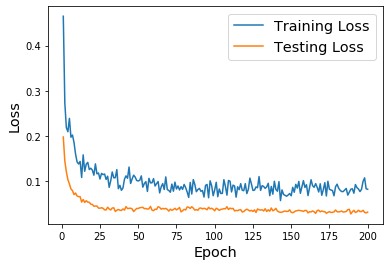

In [31]:
x = range(1, 201)

fig, ax = plt.subplots()
ax.plot(x, train_loss, label='Training Loss')
ax.plot(x, test_loss, label='Testing Loss')
ax.set_xlabel('Epoch', fontsize='x-large')
ax.set_ylabel('Loss', fontsize='x-large')
legend = ax.legend(loc='upper right', fontsize='x-large')

plt.savefig('loss.png', format='png', dpi=600, transparent=True)

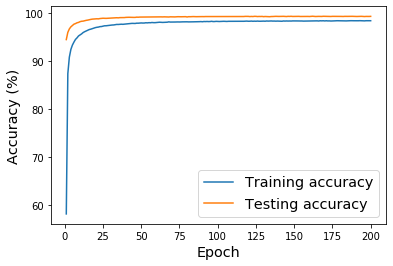

In [32]:
fig, ax = plt.subplots()
ax.plot(x, train_accuracy, label='Training accuracy')
ax.plot(x, test_accuracy, label='Testing accuracy')
ax.set_xlabel('Epoch', fontsize='x-large')
ax.set_ylabel('Accuracy (%)', fontsize='x-large')
legend = ax.legend(loc='lower right', fontsize='x-large')

plt.savefig('acc.png', format='png', dpi=600, transparent=True)

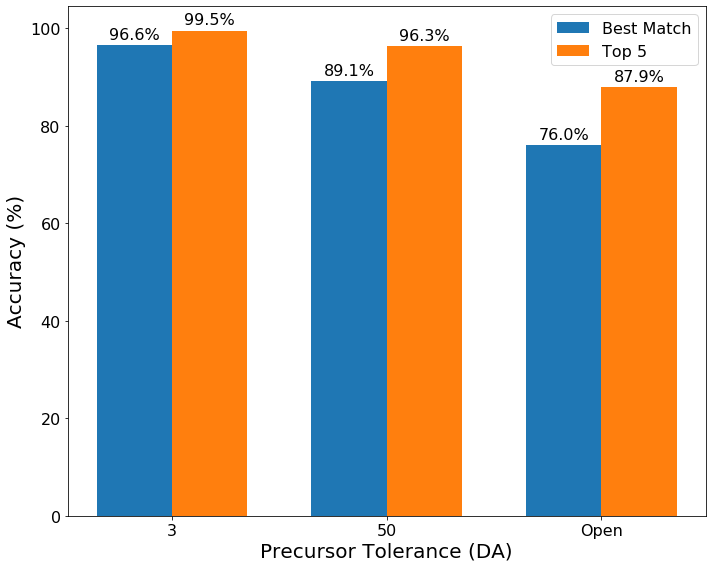

In [9]:
x_ticks = ['3', '50', 'Open']
x = np.arange(len(x_ticks))
y_top = [96.6, 89.1, 76.0]
y_top_5 = [99.5, 96.3, 87.9]
width = 0.35


fig, ax = plt.subplots(figsize=(10, 8))
ax1 = ax.bar(x - width/2, y_top, width=width, label='Best Match')
ax2 = ax.bar(x + width/2, y_top_5, width=width, label='Top 5')

ax.set_xticks(x)
ax.set_xticklabels(x_ticks, fontsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.set_xlabel('Precursor Tolerance (DA)', fontsize=20)
ax.set_ylabel('Accuracy (%)', fontsize=20)
legend = ax.legend(loc='upper right', fontsize=16)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=16)


autolabel(ax1)
autolabel(ax2)
fig.tight_layout()
plt.savefig('db-search.png', format='png', dpi=600, transparent=True)

In [ ]:
output.show()

In [ ]:
torch.save(model, 'models/hard_triplet_98.1%_charge_multi-specie.pt')

remove modifications  
use one charge

In [ ]:
T = torch.tensor([[1., 1.], [1., 2.], [3., 4.]])
S = torch.tensor([[2., 3.], [3., 2.], [4., 3.], [5, 3]])

mul = torch.mm(T, S.t())
print('mul: ')
print(mul)
adder = torch.tensor([1., 2., 3., 4.])
added = adder + mul
print('added: ')
print(added)

norm = T.pow(2).sum(1)
print(norm)
exp_norm = norm.expand(4, -1).t()
print(exp_norm)
# pdist = nn.PairwiseDistance(p=2)
# output = pdist(T, S)
# output
# print(T)
# print(T.t())
# test = torch.tensor([1, 2, 3])
# expanded_test = test.expand(3, -1)
# print(expanded_test)

In [ ]:
def pairwise_distance(A, B):
    """Compute the 2D matrix of distances between all the embeddings.

    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = torch.mm(A, B.t())

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    
    A_L2_norm = A.pow(2).sum(1)
    B_L2_norm = B.pow(2).sum(1)
    
    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = A_L2_norm[:, None] - (2.0 * dot_product) + B_L2_norm
    
    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = torch.max(distances, torch.tensor(0.0))

#     if not squared:
#         # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
#         # we need to add a small epsilon where distances == 0.0
#         mask = tf.to_float(tf.equal(distances, 0.0))
#         distances = distances + mask * 1e-16

#         distances = tf.sqrt(distances)

#         # Correct the epsilon added: set the distances on the mask to be exactly 0.0
#         distances = distances * (1.0 - mask)

    return distances

In [ ]:
dists = pairwise_distance(T, T)
print(T)
print(S)
print(dists)

In [ ]:
T = torch.tensor([[1., 1.], [1., 2.], [3., 4.]])  
S = torch.tensor([[2., 3.], [3., 2.], [4., 3.], [5, 3]])

In [ ]:
def pairwise_distances(x, y=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y_t = torch.transpose(y, 0, 1)
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y_t = torch.transpose(x, 0, 1)
        y_norm = x_norm.view(1, -1)
    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    # Ensure diagonal is zero if x=y
    if y is None:
        dist = dist - torch.diag(dist.diag())
    dist[dist != dist] = 0 # set all nan values to zero
    return torch.clamp(dist, 0.0, np.inf)

In [ ]:
a = torch.tensor([[ 1.4335, -1.0990, -0.8586],
        [ 2.1553,  2.7028, -0.8020],
        [ 1.0524,  0.1599, -0.0374]])
b = torch.tensor([[ 3., 7., 2.],
                [ 6.,  8., 2.],
                [ 9.,  5., 7.]])
dists = process.pairwise_distances(x=a, y=None)
print(dists)
print(b.max(1).values)
print(b[b.max(1).indices])
#print(b.max(0))

In [ ]:
a = torch.tensor([[ 3., 1., 4.],
                [ 0.,  2., 3.],
                [ 5.,  3., 6.]])
b = torch.tensor([[ 1., 2., 1.],
                [ 2.,  2., 1.],
                [ 1.,  1., 1.]])
dist = (a - b) ** 2
print(l2_squared(a, b))
print(torch.sum(l2_squared(a, b), 1))
print(a.min(1).values)

In [ ]:
a0 = torch.tensor([1., -1., 3.])
max0 = torch.max(a0, torch.tensor(0.))
print(max0)

In [ ]:
a = np.asarray([1, 2, 3, 4])
b = np.asarray([0, 1, 0])
a.append(b)
print(a)

In [ ]:
def test_print(i):
    print(i)

In [ ]:
with redirect_output("test.txt"):
    i = 0
    while True:
        test_print(i)
        i += 1

In [ ]:
line = "Name: AAAAAAAAAAAAAAAGAGAGAK/2_0"
name_groups = re.search(r"Name:\s(?P<pep>[a-zA-Z]+)/(?P<charge>\d+)"
                                    r"(?:_(?P<num_mods>\d+)(?P<mods>.*))?", line)
pep = name_groups['pep']
l_charge = int(name_groups['charge'])
modified = (name_groups['num_mods']) != '0'

print(pep)
print(l_charge)
print(modified)

In [68]:
te = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8])
print(te.long())
for i in range(100):
    print(te[-i:])

tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([8])
tensor([7, 8])
tensor([6, 7, 8])
tensor([5, 6, 7, 8])
tensor([4, 5, 6, 7, 8])
tensor([3, 4, 5, 6, 7, 8])
tensor([2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7, 8])
tensor([1, 2, 3, 4, 5, 6, 7,